<a href="https://colab.research.google.com/github/ankitgoel2001/Image-Clustering/blob/main/Image_Clustering_project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #get the device type: CPU or GPU

CUDA is available!  Training on GPU ...


In [ ]:

import torchvision
import torchvision.transforms as transforms

########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].

BATCH_SIZE = 128

train_transform = transforms.Compose(
    [
      transforms.Resize(256),
      transforms.RandomAffine(scale=(0.9, 1.1), translate=(0.1, 0.1), degrees=10),
      transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
      transforms.RandomHorizontalFlip(0.5),
      transforms.RandomCrop(224, padding_mode="reflect", pad_if_needed=True),  # -
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]
    )

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_transform = transforms.Compose(
    [
     transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]
    )

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
for image,label in trainset:
    print("Image shape: ",image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

classes = trainset.classes
print("Classes: ", classes)

Image shape:  torch.Size([3, 224, 224])
Image tensor:  tensor([[[-1.0000, -1.0000, -1.0000,  ...,  1.0000,  0.9451,  0.9373],
         [-1.0000, -1.0000, -1.0000,  ...,  0.9843,  0.9451,  0.9137],
         [-1.0000, -1.0000, -1.0000,  ...,  0.9451,  0.9373,  0.9059],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ...,  0.5451,  0.4667,  0.4667],
         [-1.0000, -1.0000, -1.0000,  ...,  0.5059,  0.4588,  0.4510],
         [-1.0000, -1.0000, -1.0000,  ...,  0.4667,  0.4510,  0.4196],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ...,  0.2784,  0.2157, 

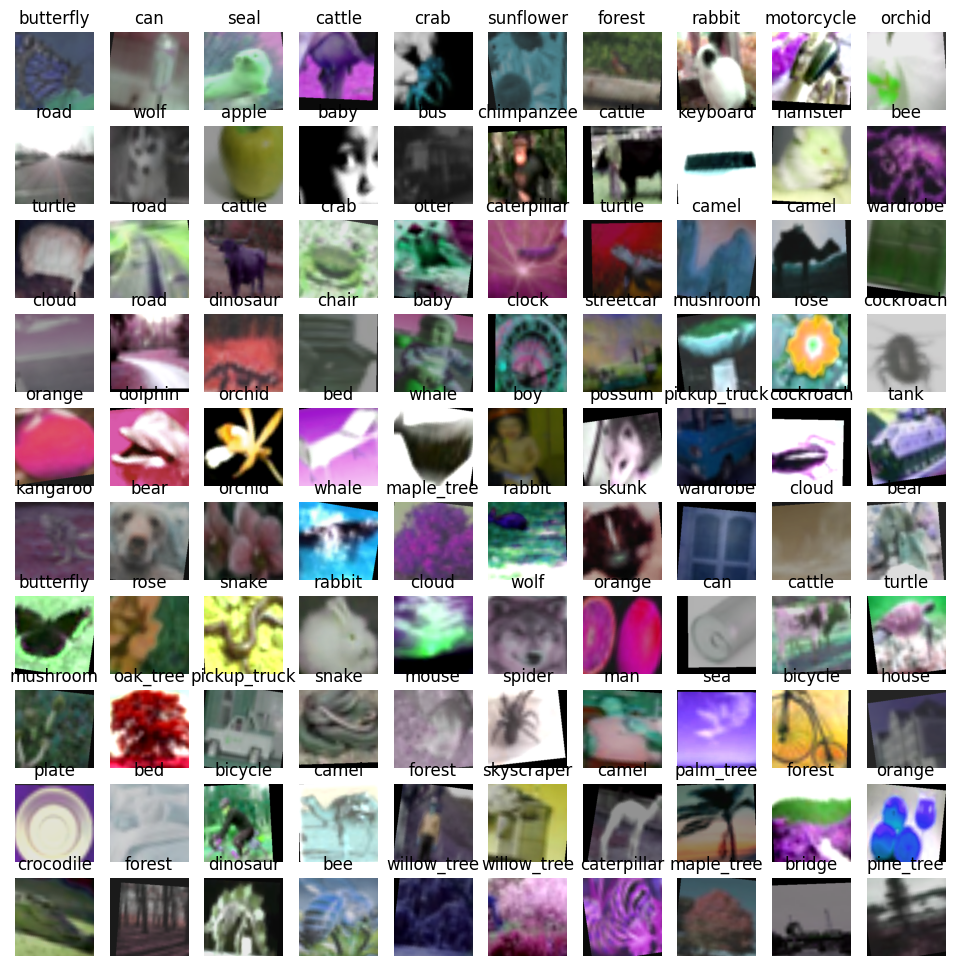

In [ ]:
########################################################################
# Let us visualize a one batch of training data

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img, sub):
    img = img / 2 + 0.5  # unnormalize
    sub.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    sub.axis("off")

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy() #convert images to numpy for display

# show 100 images
fig, subs = plt.subplots(10, 10, figsize=(12, 12))
for i, sub in enumerate(subs.flatten()):
  imshow(images[i], sub)
  sub.set_title(classes[labels[i]])

Visualizing the image detail of class:  couch


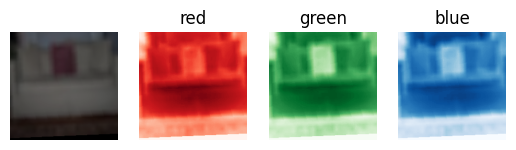

In [ ]:
########################################################################
#Here we view the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images

rgb_img = np.squeeze(images[0])
channels = ['composite', 'red', 'green', 'blue']
cmaps = [None, 'Reds', 'Greens', 'Blues']

print("Visualizing the image detail of class: ", classes[labels[0]])
fig, subs = plt.subplots(1, 4)
for i, sub in enumerate(subs.flatten()):
    if i == 0:
        imshow(rgb_img, sub)
    else:
        img = rgb_img[i-1]
        sub.imshow(img, cmap=cmaps[i])
        sub.set_title(channels[i])
        sub.axis("off")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveModel(nn.Module):
    def __init__(self, base_model, out_dim):
        super(ContrastiveModel, self).__init__()
        self.backbone = base_model
        self.fc = nn.Sequential(
            nn.Linear(self.backbone.fc.in_features, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )
        self.backbone.fc = nn.Identity()

    def forward(self, x):
        h = self.backbone(x)
        z = self.fc(h)
        return F.normalize(z, dim=1)

# Load a pre-trained ResNet model
base_model = torchvision.models.resnet18(pretrained=True)
model = ContrastiveModel(base_model, out_dim=128).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]


In [ ]:
import torch.optim as optim

# Define contrastive loss (e.g., NT-Xent loss)
class NTXentLoss(nn.Module):
    def __init__(self, temperature): # Removed batch_size from init
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_function = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        N = 2 * z_i.shape[0] # Dynamically calculate batch size
        z = torch.cat((z_i, z_j), dim=0)
        sim = self.similarity_function(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        mask = self.mask_correlated_samples(z_i.shape[0]).to(sim.device) # Create mask based on actual batch size

        sim_i_j = torch.diag(sim, z_i.shape[0])
        sim_j_i = torch.diag(sim, -z_i.shape[0])
        positives = torch.cat((sim_i_j, sim_j_i), dim=0)
        negatives = sim[mask].view(N, -1)
        labels = torch.zeros(N).to(positives.device).long()
        logits = torch.cat((positives.unsqueeze(1), negatives), dim=1)
        loss = self.criterion(logits, labels)
        return loss / N

# Training loop
def train_contrastive(model, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for (images, _) in train_loader:
            images = images.cuda()  # Remove the concatenation of images
            optimizer.zero_grad()
            features = model(images)
            # Pass a batch of images and their augmented versions separately
            loss = criterion(features, model(images))  # Assuming you have an augmentation function
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Initialize optimizer and loss function (adjust batch_size if needed)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = NTXentLoss(temperature=0.5)  # Removed batch_size from here

# Train the model
train_contrastive(model, trainloader, optimizer, criterion, epochs=5)

Epoch [1/5], Loss: 3.6104
Epoch [2/5], Loss: 3.6026
Epoch [3/5], Loss: 3.5964
Epoch [4/5], Loss: 3.5924
Epoch [5/5], Loss: 3.5911


In [ ]:
def extract_features(model, data_loader):
    model.eval()
    features = []
    with torch.no_grad():
        for (images, _) in data_loader:
            images = images.cuda()
            features.append(model.backbone(images).cpu().numpy())
    return np.concatenate(features, axis=0)

train_features = extract_features(model, trainloader)


In [ ]:
from sklearn.cluster import KMeans

num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(train_features)
labels = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


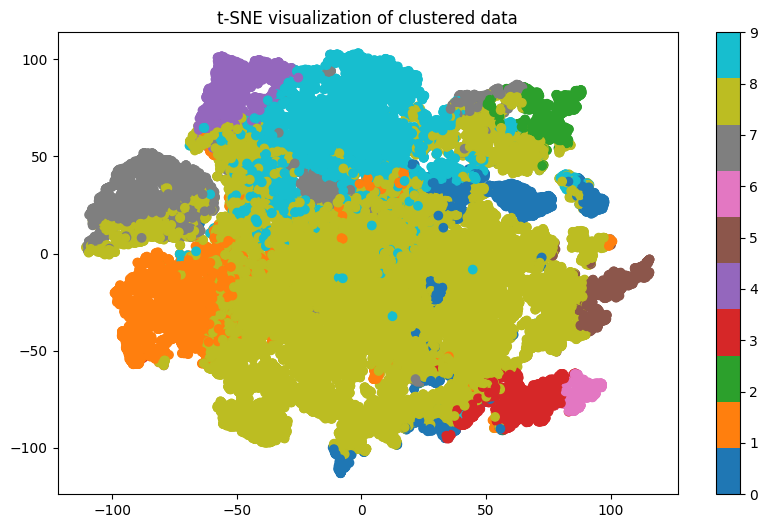

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(train_features)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.title('t-SNE visualization of clustered data')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(train_features, labels)
print(f'Silhouette Score: {silhouette_avg:.4f}')

Silhouette Score: 0.1690


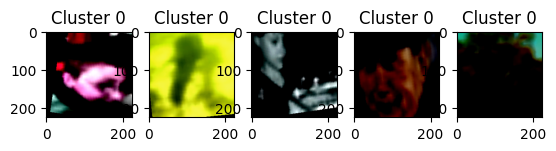

In [ ]:
def plot_cluster_examples(data_loader, labels, cluster_idx, num_examples=5):
    idxs = np.where(labels == cluster_idx)[0][:num_examples]
    for i, idx in enumerate(idxs):
        image, _ = data_loader.dataset[idx]
        plt.subplot(1, num_examples, i + 1)
        # Convert the PyTorch tensor to a NumPy array and transpose the dimensions
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title(f'Cluster {cluster_idx}')
    plt.show()

# Plot examples from cluster 0
plot_cluster_examples(trainloader, labels, cluster_idx=0)

In [ ]:


# Momentum Contrast
class MomentumContrast(nn.Module):
    def __init__(self, encoder_q, encoder_k, temperature):
        super(MomentumContrast, self).__init__()
        self.encoder_q = encoder_q
        self.encoder_k = encoder_k
        self.temperature = temperature

    def forward(self, x_i, x_j):
        # Encode the two views
        z_i = self.encoder_q(x_i)
        z_j = self.encoder_k(x_j)

        # Normalize the encodings
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)

        # Compute the similarity between the encodings
        similarity = torch.matmul(z_i, z_j.T) / self.temperature

        # Create the labels (i.e., which view corresponds to which image)
        labels = torch.arange(x_i.shape[0]).to(similarity.device)

        # Compute the loss
        loss = F.cross_entropy(similarity, labels)

        return loss

train_contrastive(model, trainloader, optimizer, criterion, epochs=5)
train_features = extract_features(model, trainloader)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(train_features)
labels = kmeans.labels_
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(train_features)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.title('t-SNE visualization of clustered data')
plt.show()